In [9]:
!pip install fastai

In [10]:
import pandas as pd
from fastai.imports import *

In [11]:
dataset_path = "/kaggle/input/us-patent-phrase-to-phrase-matching"


##   EDA

In [12]:
df_train = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv')
df_train.info()
df_train.describe()
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [13]:
eval_df = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv')
eval_df.describe()
eval_df.info()
eval_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04
5,474c874d0c07bd21,dry corn,dry corn starch,C12
6,442c114ed5c4e3c9,tunneling capacitor,capacitor housing,G11
7,b8ae62ea5e1d8bdb,angular contact bearing,contact therapy radiation,B23
8,faaddaf8fcba8a3f,produce liquid hydrocarbons,produce a treated stream,C10
9,ae0262c02566d2ce,diesel fuel tank,diesel fuel tanks,F02


In [14]:
print(df_train.anchor.value_counts())
print(df_train.target.value_counts())
print(df_train.context.value_counts())

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64
composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64
H01    2186
H04    2177
G01    1812
A61    1477
F

In [15]:
#creating a column to separate the section from context
df_train["section"] = df_train.context.str[0]
df_train.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

In [16]:
df_train[df_train.score==1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


#### Histogram ANalysis

<AxesSubplot:>

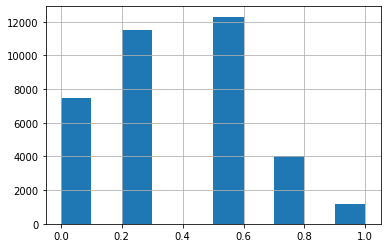

In [18]:
df_train.score.hist()

## Training

#### Import libraries for training

In [19]:
!pip install transformers
from torch.utils.data import DataLoader #load data using pytorch framework
import warnings,transformers,logging,torch #importing huggingface transformer
from transformers import TrainingArguments,Trainer #importing classes from huggingface to train and hadnle 
from transformers import AutoModelForSequenceClassification,AutoTokenizer #importing prtreained model

In [20]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [21]:
model_nm = 'microsoft/deberta-v3-small'

### create a tokenizer for the model

In [22]:
token = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

In [23]:
sep = token.sep_token
df_train['input'] =  df_train.context + sep+ df_train.target + sep+ df_train.anchor
df_train.input.tail

<bound method NDFrame.tail of 0        A47[SEP]abatement of pollution[SEP]abatement
1                A47[SEP]act of abating[SEP]abatement
2               A47[SEP]active catalyst[SEP]abatement
3           A47[SEP]eliminating process[SEP]abatement
4                 A47[SEP]forest region[SEP]abatement
                             ...                     
36468         B44[SEP]wooden article[SEP]wood article
36469             B44[SEP]wooden box[SEP]wood article
36470          B44[SEP]wooden handle[SEP]wood article
36471        B44[SEP]wooden material[SEP]wood article
36472       B44[SEP]wooden substrate[SEP]wood article
Name: input, Length: 36473, dtype: object>

#### convert pandas DataFrames into HuggingFace Datasets


In [24]:
from datasets import Dataset, DatasetDict #import classes from the datasets module from huggingface
ds_train = Dataset.from_pandas(df_train).rename_column('score','label')
eval_ds= Dataset.from_pandas(eval_df)

In [25]:
def tok_func(x): 
    return token(x["input"])
tok_func(ds_train[0])

{'input_ids': [1, 336, 5753, 2, 47284, 265, 6435, 2, 47284, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Import pre-trained language model DeBERTa**


In [26]:
!pip install transformers
!pip install sentencepiece

In [28]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer, T5ForConditionalGeneration #collect the pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_nm) #create the tokenizer class from the pretrained model

In [32]:
sep = tokenizer.sep_token
sep

'[SEP]'

In [36]:
df_train['inputs'] = df_train.context + sep + df_train.anchor + sep + df_train.target

In [38]:
ds = Dataset.from_pandas(df_train).rename_column('score', 'label')
eval_ds = Dataset.from_pandas(eval_df)

In [40]:
def tok_func(x): return tokenizer(x["inputs"])
tok_func(ds[0])
tokenizer.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [43]:
inps = "anchor","target","context"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))
tok_ds[0]

  0%|          | 0/37 [00:00<?, ?ba/s]

{'label': 0.5,
 'input': 'A47[SEP]abatement of pollution[SEP]abatement',
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Validation set

In [45]:
anchors = df_train.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

In [46]:
val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]

In [49]:
is_val = np.isin(df_train.anchor, val_anchors)
idxs = np.arange(len(df_train))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(9116, 27357)

In [50]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})

In [53]:
df_train.iloc[trn_idxs].score.mean(),df_train.iloc[val_idxs].score.mean()

(0.3623021530138539, 0.3613426941641071)

## training model

In [55]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [56]:
lr,bs = 8e-5,128
wd,epochs = 0.01,4

In [57]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

In [58]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [60]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokenizer, compute_metrics=corr)

In [61]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.030229,0.795818
2,No log,0.025109,0.808220
3,0.032900,0.024015,0.815388
4,0.032900,0.024616,0.816341


#### 